## Imports

In [ ]:
!pip install python-binance

!pip install torchinfo

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pickle


# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# Locate in drive (change this to your location)
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'stock_prediction/order_book_data/'


# Import custom modules
import sys
sys.path.append(base_dir)
from ftx_client import FtxClient as Client


## Modules

In [ ]:
## DATA AUGMENTATION --------------------------------------

def correlated_noise_surrogates(original_data):
    """
    Return Fourier surrogates.

    Generate surrogates by Fourier transforming the :attr:`original_data`
    time series (assumed to be real valued), randomizing the phases and
    then applying an inverse Fourier transform. Correlated noise surrogates
    share their power spectrum and autocorrelation function with the
    original_data time series.

    The Fast Fourier transforms of all time series are cached to facilitate
    a faster generation of several surrogates for each time series. Hence,
    :meth:`clear_cache` has to be called before generating surrogates from
    a different set of time series!

    .. note::
        The amplitudes are not adjusted here, i.e., the
        individual amplitude distributions are not conserved!

    **Examples:**

    The power spectrum is conserved up to small numerical deviations:

    >>> ts = Surrogates.SmallTestData().original_data
    >>> surrogates = Surrogates.\
            SmallTestData().correlated_noise_surrogates(ts)
    >>> all(r(np.abs(np.fft.fft(ts,         axis=1))[0,1:10]) == \
            r(np.abs(np.fft.fft(surrogates, axis=1))[0,1:10]))
    True

    However, the time series amplitude distributions differ:

    >>> all(np.histogram(ts[0,:])[0] == np.histogram(surrogates[0,:])[0])
    False

    :type original_data: 2D array [index, time]
    :arg original_data: The original time series.
    :rtype: 2D array [index, time]
    :return: The surrogate time series.
    """

    #  Calculate FFT of original_data time series
    #  The FFT of the original_data data has to be calculated only once,
    #  so it is stored in self._original_data_fft.
    surrogates = np.fft.rfft(original_data, axis=1)

    #  Get shapes
    (N, n_time) = original_data.shape
    len_phase = surrogates.shape[1]

    #  Generate random phases uniformly distributed in the
    #  interval [0, 2*Pi]
    phases = np.random.uniform(low=0, high=2 * np.pi, size=(N, len_phase))

    #  Add random phases uniformly distributed in the interval [0, 2*Pi]
    surrogates *= np.exp(1j * phases)

    #  Calculate IFFT and take the real part, the remaining imaginary part
    #  is due to numerical errors.
    return np.ascontiguousarray(np.real(np.fft.irfft(surrogates, n=n_time,
                                                        axis=1)))

def AAFT_surrogates(original_data):
    """
    Return surrogates using the amplitude adjusted Fourier transform
    method.

    Reference: [Schreiber2000]_

    :type original_data: 2D array [index, time]
    :arg original_data: The original time series.
    :rtype: 2D array [index, time]
    :return: The surrogate time series.
    """
    #  Create sorted Gaussian reference series
    gaussian = np.random.randn(original_data.shape[0], original_data.shape[1])
    gaussian.sort(axis=1)

    #  Rescale data to Gaussian distribution
    ranks = original_data.argsort(axis=1).argsort(axis=1)
    rescaled_data = np.zeros(original_data.shape)

    for i in range(original_data.shape[0]):
        rescaled_data[i, :] = gaussian[i, ranks[i, :]]

    #  Phase randomize rescaled data
    phase_randomized_data = correlated_noise_surrogates(rescaled_data)

    #  Rescale back to amplitude distribution of original data
    sorted_original = original_data.copy()
    sorted_original.sort(axis=1)

    ranks = phase_randomized_data.argsort(axis=1).argsort(axis=1)

    for i in range(original_data.shape[0]):
        rescaled_data[i, :] = sorted_original[i, ranks[i, :]]

    return rescaled_data

def refined_AAFT_surrogates(original_data, n_iterations, output="true_amplitudes"):
    """
    Return surrogates using the iteratively refined amplitude adjusted
    Fourier transform method.

    A set of AAFT surrogates (:meth:`AAFT_surrogates`) is iteratively
    refined to produce a closer match of both amplitude distribution and
    power spectrum of surrogate and original data.

    Reference: [Schreiber2000]_

    :type original_data: 2D array [index, time]
    :arg original_data: The original time series.
    :arg int n_iterations: Number of iterations / refinement steps
    :arg str output: Type of surrogate to return. "true_amplitudes":
        surrogates with correct amplitude distribution, "true_spectrum":
        surrogates with correct power spectrum, "both": return both outputs
        of the algorithm.
    :rtype: 2D array [index, time]
    :return: The surrogate time series.
    """
    #  Get size of dimensions
    n_time = original_data.shape[1]

    #  Get Fourier transform of original data with caching
    fourier_transform = np.fft.rfft(original_data, axis=1)

    #  Get Fourier amplitudes
    original_fourier_amps = np.abs(fourier_transform)

    #  Get sorted copy of original data
    sorted_original = original_data.copy()
    sorted_original.sort(axis=1)

    #  Get starting point / initial conditions for R surrogates
    # (see [Schreiber2000]_)
    R = AAFT_surrogates(original_data)

    #  Start iteration
    for i in range(n_iterations):
        #  Get Fourier phases of R surrogate
        r_fft = np.fft.rfft(R, axis=1)
        # r_phases = r_fft / np.abs(r_fft)
        a  = r_fft
        b = np.abs(r_fft)
        r_phases = np.divide(a, b, out = np.zeros(a.shape, dtype=np.clongdouble), where=b!=0)
        #  Transform back, replacing the actual amplitudes by the desired
        #  ones, but keeping the phases exp(iψ(i)
        s = np.fft.irfft(original_fourier_amps * r_phases, n=n_time,
                            axis=1)

        #  Rescale to desired amplitude distribution
        ranks = s.argsort(axis=1).argsort(axis=1)

        for j in range(original_data.shape[0]):
            R[j, :] = sorted_original[j, ranks[j, :]]

    if output == "true_amplitudes":
        return R
    elif output == "true_spectrum":
        return s
    elif output == "both":
        return (R, s)
    else:
        return (R, s)



class DataTransformer:
    def __init__(self, mix_coef = np.pi/6, num_iter = 2):
        self.mix_coef = mix_coef
        self.num_iter = num_iter

    def transform(self, x):
        transposed_data = x.T
        surrogated_data = refined_AAFT_surrogates(transposed_data,n_iterations=self.num_iter, output='true_spectrum')
        new_data = np.cos(self.mix_coef)*transposed_data + np.sin(self.mix_coef)*surrogated_data
        return new_data.T


class TimeseriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, pytorch_test_dataset_dict, scale_proportion = 0.2):
        self.X = X
        self.y = y
        self.seq_len = pytorch_test_dataset_dict['seq_len']
        self.skip_step = pytorch_test_dataset_dict['skip_step']
        self.transformer = DataTransformer()
        self.transform_data = pytorch_test_dataset_dict['transform_data']
        self.is_regression = pytorch_test_dataset_dict['is_regression']
        self.scaling = pytorch_test_dataset_dict['scaling']
        self.scale_proportion = scale_proportion

    def __len__(self):
        return self.X.__len__() - (self.seq_len)*self.skip_step

    def __getitem__(self, index):

        arr = np.asarray(self.X[index:index+(self.seq_len*self.skip_step)],dtype=np.float32)
        instance  = arr.reshape(-1, self.skip_step, arr.shape[1]).mean(axis = 1)
        target = np.asarray(self.y[(index+(self.seq_len)*self.skip_step)-1],dtype=np.float32)

        if self.transform_data == 1:
            instance = self.transformer.transform(instance)

        if self.scaling == 1:
            scaling_factor = np.random.uniform(1.0-self.scale_proportion, 1.0+self.scale_proportion)
            instance = instance * scaling_factor
            if self.is_regression == 1:
                target = target * scaling_factor

        return (np.asarray(instance,dtype=np.float32),np.asarray(target,dtype=np.float32))

class TimeDistributed(torch.nn.Module):
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

class LSTMNet(torch.nn.Module):
    def __init__(self, model_parameters_dict):
        super(LSTMNet, self).__init__()

        self.input_features = model_parameters_dict['input_features']
        self.output_size = model_parameters_dict['output_size']
        self.embed_dim = model_parameters_dict['embed_dim']
        self.hidden_dim = model_parameters_dict['hidden_dim']
        self.n_layers = model_parameters_dict['n_layers']
        self.device = model_parameters_dict['device']
        self.drop_prob = model_parameters_dict['drop_prob']
        self.regression = model_parameters_dict['regression']

        self.embedding = TimeDistributed(torch.nn.Linear(self.input_features, self.embed_dim))
        self.lstm = torch.nn.LSTM(self.embed_dim, self.hidden_dim, self.n_layers, dropout=self.drop_prob, batch_first=True)
        self.dropout = torch.nn.Dropout(self.drop_prob)

        # DESDE: ESTAS LINEAS CAMBIARON <----------------------------------------------
        self.fc = torch.nn.Linear(self.hidden_dim*self.n_layers, self.embed_dim)
        # HASTA: ESTAS LINEAS CAMBIARON <----------------------------------------------

        self.fc_out = torch.nn.Linear(self.embed_dim, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        # embeds = self.sigmoid(embeds)

        # DESDE: ESTAS LINEAS CAMBIARON <----------------------------------------------
        lstm_out, (hidden,cell) = self.lstm(embeds)
        lstm_out = hidden.contiguous().view(batch_size, self.hidden_dim*self.n_layers) # ANTES: lstm_out[:,-1,:].contiguous().view(-1, self.hidden_dim)
        # HASTA: ESTAS LINEAS CAMBIARON <----------------------------------------------

        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        out = self.fc_out(out)

        if self.regression == False:
            out = self.sigmoid(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
        return hidden


In [ ]:


# FUNCTION TO CREATE DATASET ---------------------------------------------------

def create_dataset(data_candle_filtered, filtered_data_ob, dataset_param):

    pred_steps = dataset_param['pred_steps']
    train_ratio = dataset_param['train_ratio']
    scaling_log_returns = dataset_param['scaling_log_returns']
    regression = dataset_param['regression']
    target_folder = dataset_param['target_folder']
    file_prefix = dataset_param['file_prefix']

    merged_dataset = pd.merge(data_candle_filtered, filtered_data_ob, on="timestamp", how='inner')

    log_returns_close_pred = np.convolve([1]*pred_steps, merged_dataset.log_returns_close.values[1:],mode='valid')
    big_dataset = merged_dataset.iloc[:-pred_steps].copy()

    big_dataset['y'] = log_returns_close_pred

    big_dataset.dropna(inplace = True)

    data_shape = big_dataset.shape
    big_dataset['train'] = False
    big_dataset.loc[:int(data_shape[0]*train_ratio), 'train'] = True

    X_train = big_dataset[big_dataset.train].drop(columns = ['timestamp', 'train','y'])
    X_test = big_dataset[~big_dataset.train].drop(columns = ['timestamp', 'train','y'])

    #if regression == True:
    if True:
        close_returns_values_train =  X_train['log_returns_close'].copy().values * scaling_log_returns
        close_returns_values_test = X_test['log_returns_close'].copy().values * scaling_log_returns

        X_train.drop(columns='log_returns_close',inplace=True)
        X_test.drop(columns='log_returns_close',inplace=True)

    y_train = np.asarray(big_dataset[big_dataset.train]['y'].values)
    y_test = np.asarray(big_dataset[~big_dataset.train]['y'].values)

    feature_list = X_train.columns
    feature_list = list(feature_list.values)

    ss = StandardScaler()
    #ss = MinMaxScaler(feature_range=(-1, 1))
    X_train = ss.fit_transform(X_train.values)
    X_test = ss.transform(X_test.values)
    #sacaler_parameters = ss.get_params()
    pickle.dump(ss, open(target_folder + file_prefix + 'std_scaler.pkl','wb'))

    #if regression == True:
    if True:
        X_train = np.concatenate((X_train, close_returns_values_train.reshape(-1,1)), axis=1)
        X_test = np.concatenate((X_test, close_returns_values_test.reshape(-1,1)), axis=1)
        feature_list.append('log_returns_close')

    # PRUEBAAA
    #X_test = X_test[int(data_shape[0]*0.1466):]
    #y_test = y_test[int(data_shape[0]*0.1466):]

    return X_train, X_test, y_train, y_test, feature_list, big_dataset

## Create the dataset and dataloaders

Baseline Train:  50.76259812095822
Mayority Train: Up
Baseline Test:  51.10502283105023
Mayority Test: Up


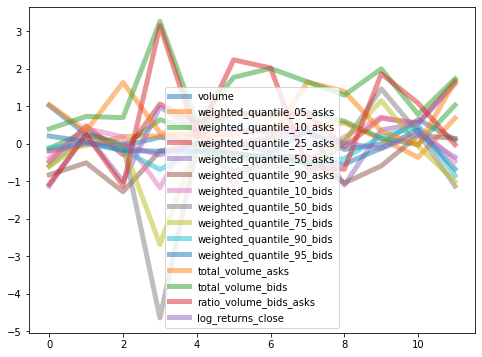

Number of intances: 49174
Number independent intances: 273
Batch Size: 32
compute loss every: 500
Batch in training: 1536


In [ ]:
# CREATING DATASET

X_train, X_test, y_train, y_test, feature_list, big_dataset = create_dataset(data_candle_filtered, filtered_data_ob, dataset_param_dict)

# CREATING DATALOADERS

train_dataset = TimeseriesDataset(X_train, y_train, pytorch_train_dataset_dict)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last=True, num_workers = False)

test_dataset = TimeseriesDataset(X_test, y_test, pytorch_test_dataset_dict)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last=True, num_workers = False)


# PRINT DATASET STATISTICS

bool_y_train = y_train > 0
proportion_train = np.mean(bool_y_train)
baseline_train = 100*np.max([proportion_train,1-proportion_train])
if proportion_train > 1-proportion_train:
    label_train = 'Up'
else:
    label_train = 'Down'
print('Baseline Train: ',baseline_train)
print('Mayority Train: '+ label_train)

bool_y_test = y_test > 0
proportion_test = np.mean(bool_y_test)
baseline_test = 100*np.max([proportion_test,1-proportion_test])
if proportion_test > 1-proportion_test:
    label_test = 'Up'
else:
    label_test = 'Down'

print('Baseline Test: ',baseline_test)
print('Mayority Test: '+ label_test)


# PRINT RANDOM INSTANCE

num_ins = 100
ins = train_dataset.__getitem__(num_ins)[0]

plt.figure(figsize=(8,6))
for i in range(len(feature_list)):
    plt.plot(ins[:,i],alpha=0.5, label = feature_list[i], linewidth=5.0)
plt.legend()
plt.show()

num_intances_train = X_train.shape[0]
total_length_intances = SEQ_LEN * SKIP_STEP
num_independent_intances = int(num_intances_train/total_length_intances)
compute_loss_step = 100 * int(num_intances_train/(BATCH_SIZE * num_independent_intances))

print('Number of intances:',num_intances_train)
print('Number independent intances:',num_independent_intances)
print('Batch Size:', BATCH_SIZE)
print('compute loss every:',compute_loss_step)

print('Batch in training:',int(num_intances_train/BATCH_SIZE))

## Define model and optimizer

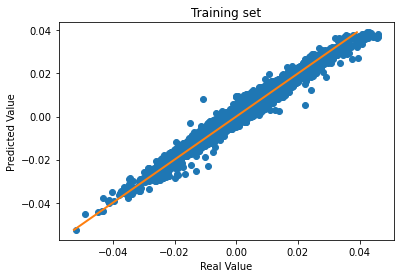

Coeficiente de Correlacion:  0.9706985150720866
P value:  0.0


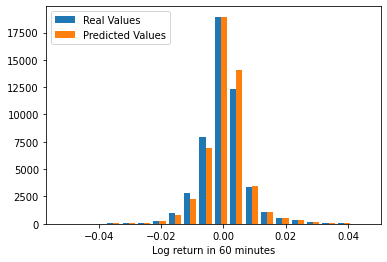

In [ ]:
list_pred_labels_train = []
list_real_labels_train  = []

for inp, lab in train_loader:
    train_h = best_model.init_hidden(BATCH_SIZE)
    train_h = tuple([each.data for each in train_h])

    inp, lab = inp.to(device), lab.to(device)
    out, train_h = best_model(inp)

    pred_labels = out.squeeze().detach().cpu().numpy()
    real_labels = lab.float().detach().cpu().numpy()

    list_pred_labels_train.append(pred_labels)
    list_real_labels_train.append(real_labels)

vec_pred_train = np.hstack(list_pred_labels_train)
vec_real_train = np.hstack(list_real_labels_train)

plt.scatter(vec_real_train,vec_pred_train)
plt.title('Training set')
plt.ylabel('Predicted Value')
plt.xlabel('Real Value')

max_x = np.max(vec_pred_train)
min_x = np.min(vec_pred_train)
plt.plot([min_x,max_x],[min_x,max_x],linewidth=2,color='C1')
plt.show()

corr, p = spearmanr(vec_real_train, vec_pred_train)
print('Coeficiente de Correlacion: ', corr)
print('P value: ', p)

plt.hist([vec_real_train, vec_pred_train],bins = 20, label=['Real Values', 'Predicted Values'])
plt.xlabel('Log return in 60 minutes')
plt.legend(loc='upper left')
plt.show()